In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import sys
from dotenv import load_dotenv
from tqdm import tqdm
tqdm.pandas()
import math
from sklearn.model_selection import train_test_split
import os
import PIL
import tensorflow.keras.backend as K
sys.path.append('../scripts/helper_functions_cv/tensorflow_helpers/')
from save_weights_every_epoch import CallbackForSavingModelWeights
from multiprocessing import Pool
from sklearn.utils import compute_class_weight
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
import tensorflow_datasets as tfds
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot
import multiprocessing as mp
sys.path.append('../scripts/')
from find_bad_ones import find_bad_ones
import pickle

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
allowed_gpus = [0]
gpus = tf.config.list_physical_devices("GPU")
final_gpu_list = [gpus[x] for x in allowed_gpus]
tf.config.set_visible_devices(final_gpu_list, "GPU")

strategy = tf.distribute.MirroredStrategy()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [4]:
print(REPLICAS)

1


In [5]:
load_dotenv('../config_files/dev.env')

True

In [6]:
with open('./data.pickle', 'rb') as handle:
    updated_train_csv = pickle.load(handle)

def split_datasets(data, test_size = 0.01):
    train, test = train_test_split(data, test_size = test_size, random_state = 42) 
    train, val = train_test_split(train, test_size = test_size, random_state = 42)
    return train, val, test

In [7]:
train, val, test = split_datasets(updated_train_csv)

train_labels = train['class_labels'].values.tolist()
computed = compute_class_weight(class_weight='balanced', classes=[0, 1], y=train_labels)
class_weight_dict = {
    0: computed[0],
    1: computed[1]
}

In [8]:
def read_train_imgs(img, label, shape):
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = shape)
    img = img / 255
    return img, label

def get_data(data, shape = (256, 256), shuffle = True, repeat = True, batch = True, batch_size = 32):
    imgs, labels = data['fixed_paths'].values.tolist(), data['class_labels'].values.tolist()
    shapes = [shape for x in range(len(imgs))]
    tensor = tf.data.Dataset.from_tensor_slices((imgs, labels, shapes))
    tensor = tensor.cache()
    if repeat:
        tensor = tensor.repeat()
    if shuffle:
        tensor = tensor.shuffle(8048 * 1)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        tensor = tensor.with_options(opt)
    tensor = tensor.map(read_train_imgs)
    if batch:
        tensor = tensor.batch(batch_size * REPLICAS)
    tensor = tensor.prefetch(AUTO)
    return tensor

In [9]:
def create_model(model_name, shape):
    with strategy.scope():
        input_layer = tf.keras.Input(shape = shape)
        construct = getattr(keras.applications, model_name)
        mid_layer = construct(include_top = False, 
                            weights = None, 
                            pooling = 'avg')(input_layer)
        last_layer = keras.layers.Dense(1, activation = 'sigmoid')(mid_layer)
        model = keras.Model(input_layer, last_layer)
    return model
def compile_new_model(model):
    with strategy.scope():
        loss = keras.losses.BinaryCrossentropy(label_smoothing=0.05)
        optimizer = keras.optimizers.SGD()
        prec = keras.metrics.Precision(name = 'prec')
        rec = keras.metrics.Recall(name = 'rec')
        model.compile(
            loss = loss,
            optimizer = optimizer,
            metrics = [prec, rec]
        )
    return model

In [10]:
os.environ['tb_path']

'/home/ubuntu/ship_segmentation/TB/'

In [15]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}classification/res_50_baseline/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/classification/res_50_baseline/'
weights_save = CallbackForSavingModelWeights(weights_path)
batch_size = 128
train_dataset = get_data(train, shape=(32, 32), batch_size = batch_size)
val_dataset = get_data(val, shape=(32, 32), repeat = False, shuffle = False, batch_size=batch_size)
model = create_model('ResNet50', (32, 32, 3))
model = compile_new_model(model)
model_hist = model.fit(
    train_dataset,
    validation_data = val_dataset,
    verbose = 1,
    epochs = 30,
    steps_per_epoch = len(train) // (batch_size * REPLICAS),
    callbacks = [
        tensorboard_callback,
        weights_save
    ],
)

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1
184/184 [==============================] - 185s 259ms/step - loss: 0.6816 - prec: 0.3246 - rec: 0.1562 - val_loss: 0.5668 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00
Epoch 2/30
184/184 [==============================] - 39s 210ms/step - loss: 0.5519 - prec: 0.4758 - rec: 0.2385 - val_loss: 0.5562 - val_prec: 0.5000 - val_rec: 0.0023
Epoch 3/30
184/184 [==============================] - 38s 209ms/step - loss: 0.5122 - prec: 0.5281 - rec: 0.2991 - val_loss: 0.5565 - val_prec: 0.6588 - val_rec: 0.1299
Epoch 4/30
184/184 [==============================] - 38s 208ms/step - loss: 0.4811 - prec: 0.5765 - rec: 0.3441 - val_loss: 0.4640 - val_prec: 0.5734 - val_rec: 0.3898
Epoch 5/30
184/184 [==============================] - 38s 206ms/step - loss: 0.4670 - prec: 0.5966 - rec: 0.3887 - val_loss: 0.4673 - val_pre

In [16]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}classification/res_50_baseline_v1/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/classification/res_50_baseline/'
weights_save = CallbackForSavingModelWeights(weights_path, epoch_number=31)
batch_size = 128
train_dataset = get_data(train, shape=(32, 32), batch_size = batch_size)
val_dataset = get_data(val, shape=(32, 32), repeat = False, shuffle = False, batch_size=batch_size)
model = create_model('ResNet50', (32, 32, 3))
model = compile_new_model(model)
model.load_weights('/home/ubuntu/ml-data-training/ship_seg_weights/classification/res_50_baseline/30.h5')
model_hist = model.fit(
    train_dataset,
    validation_data = val_dataset,
    verbose = 1,
    epochs = 30,
    steps_per_epoch = len(train) // (batch_size * REPLICAS),
    callbacks = [
        tensorboard_callback,
        weights_save
    ],
)

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1
184/184 [==============================] - 172s 242ms/step - loss: 0.3373 - prec: 0.7850 - rec: 0.6445 - val_loss: 0.4081 - val_prec: 0.6700 - val_rec: 0.6311
Epoch 2/30
184/184 [==============================] - 39s 210ms/step - loss: 0.3330 - prec: 0.7888 - rec: 0.6492 - val_loss: 0.3788 - val_prec: 0.7194 - val_rec: 0.6009
Epoch 3/30
184/184 [==============================] - 38s 207ms/step - loss: 0.3316 - prec: 0.7898 - rec: 0.6536 - val_loss: 0.3745 - val_prec: 0.7683 - val_rec: 0.6079
Epoch 4/30
184/184 [==============================] - 38s 208ms/step - loss: 0.3293 - prec: 0.7972 - rec: 0.6552 - val_loss: 0.3774 - val_prec: 0.7205 - val_rec: 0.6520
Epoch 5/30
184/184 [==============================] - 38s 208ms/step - loss: 0.3255 - prec: 0.7992 - rec: 0.6640 - val_loss: 0.4080 - val_prec: 0.787

In [18]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}classification/res_50_baseline_64/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/classification/res_50_baseline_64/'
weights_save = CallbackForSavingModelWeights(weights_path)
batch_size = 128
train_dataset = get_data(train, shape=(64, 64), batch_size = batch_size)
val_dataset = get_data(val, shape=(64, 64), repeat = False, shuffle = False, batch_size=batch_size)
model = create_model('ResNet50', (64, 64, 3))
model = compile_new_model(model)
model_hist = model.fit(
    train_dataset,
    validation_data = val_dataset,
    verbose = 1,
    epochs = 30,
    steps_per_epoch = len(train) // (batch_size * REPLICAS),
    callbacks = [
        tensorboard_callback,
        weights_save
    ],
)

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1
184/184 [==============================] - 184s 261ms/step - loss: 0.6489 - prec: 0.3073 - rec: 0.0972 - val_loss: 0.5703 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00
Epoch 2/30
184/184 [==============================] - 41s 225ms/step - loss: 0.5496 - prec: 0.4712 - rec: 0.1734 - val_loss: 0.5416 - val_prec: 0.2273 - val_rec: 0.0232
Epoch 3/30
184/184 [==============================] - 42s 227ms/step - loss: 0.5069 - prec: 0.5339 - rec: 0.2608 - val_loss: 0.5957 - val_prec: 0.4400 - val_rec: 0.0255
Epoch 4/30
184/184 [==============================] - 42s 228ms/step - loss: 0.4808 - prec: 0.5815 - rec: 0.3388 - val_loss: 0.6401 - val_prec: 0.6087 - val_rec: 0.0650
Epoch 5/30
184/184 [==============================] - 42s 226ms/step - loss: 0.4645 - prec: 0.6023 - rec: 0.3890 - val_loss: 0.6708 - val_pre

In [19]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}classification/res_50_baseline_64_v1/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/classification/res_50_baseline_64/'
weights_save = CallbackForSavingModelWeights(weights_path, epoch_number=31)
batch_size = 128
train_dataset = get_data(train, shape=(64, 64), batch_size = batch_size)
val_dataset = get_data(val, shape=(64, 64), repeat = False, shuffle = False, batch_size=batch_size)
model = create_model('ResNet50', (64, 64, 3))
model = compile_new_model(model)
model.load_weights('/home/ubuntu/ml-data-training/ship_seg_weights/classification/res_50_baseline_64/30.h5')
model_hist = model.fit(
    train_dataset,
    validation_data = val_dataset,
    verbose = 1,
    epochs = 30,
    steps_per_epoch = len(train) // (batch_size * REPLICAS),
    callbacks = [
        tensorboard_callback,
        weights_save
    ],
)

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1
184/184 [==============================] - 187s 260ms/step - loss: 0.3133 - prec: 0.8231 - rec: 0.6829 - val_loss: 0.3358 - val_prec: 0.7760 - val_rec: 0.6752
Epoch 2/30
184/184 [==============================] - 42s 230ms/step - loss: 0.3115 - prec: 0.8268 - rec: 0.6867 - val_loss: 0.3180 - val_prec: 0.8254 - val_rec: 0.6473
Epoch 3/30
184/184 [==============================] - 42s 229ms/step - loss: 0.3085 - prec: 0.8269 - rec: 0.6893 - val_loss: 0.4022 - val_prec: 0.7473 - val_rec: 0.6311
Epoch 4/30
184/184 [==============================] - 42s 229ms/step - loss: 0.3062 - prec: 0.8300 - rec: 0.6961 - val_loss: 0.3267 - val_prec: 0.8424 - val_rec: 0.6450
Epoch 5/30
184/184 [==============================] - 42s 227ms/step - loss: 0.3042 - prec: 0.8327 - rec: 0.7007 - val_loss: 0.3190 - val_prec: 0.7958 - val_rec: 0.6961
Epoch 6/30
184/184 [==============================] - 42s 229ms/ste

In [20]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}classification/res_50_baseline_128/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/classification/res_50_baseline_128/'
weights_save = CallbackForSavingModelWeights(weights_path)
batch_size = 128
train_dataset = get_data(train, shape=(128, 128), batch_size = batch_size)
val_dataset = get_data(val, shape=(128, 128), repeat = False, shuffle = False, batch_size=batch_size)
model = create_model('ResNet50', (128, 128, 3))
model = compile_new_model(model)
model_hist = model.fit(
    train_dataset,
    validation_data = val_dataset,
    verbose = 1,
    epochs = 30,
    steps_per_epoch = len(train) // (batch_size * REPLICAS),
    callbacks = [
        tensorboard_callback,
        weights_save
    ],
)

Epoch 1/30
184/184 [==============================] - 187s 297ms/step - loss: 0.6092 - prec: 0.4112 - rec: 0.1381 - val_loss: 0.6192 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00
Epoch 2/30
184/184 [==============================] - 52s 283ms/step - loss: 0.5211 - prec: 0.5183 - rec: 0.2663 - val_loss: 0.5579 - val_prec: 0.5128 - val_rec: 0.0464
Epoch 3/30
184/184 [==============================] - 52s 283ms/step - loss: 0.4843 - prec: 0.5614 - rec: 0.3410 - val_loss: 0.6362 - val_prec: 0.4049 - val_rec: 0.6566
Epoch 4/30
184/184 [==============================] - 52s 282ms/step - loss: 0.4479 - prec: 0.6240 - rec: 0.4201 - val_loss: 0.5203 - val_prec: 0.6974 - val_rec: 0.2459
Epoch 5/30
184/184 [==============================] - 52s 283ms/step - loss: 0.4247 - prec: 0.6740 - rec: 0.4781 - val_loss: 0.5731 - val_prec: 0.5862 - val_rec: 0.4733
Epoch 6/30
184/184 [==============================] - 52s 282ms/step - loss: 0.3943 - prec: 0.7252 - rec: 0.5182 - val_loss: 0.4434 - val_prec: 0.

In [ ]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}classification/res_50_baseline_128_v1/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/classification/res_50_baseline_128/'
weights_save = CallbackForSavingModelWeights(weights_path, epoch_number = 31)
batch_size = 128
train_dataset = get_data(train, shape=(128, 128), batch_size = batch_size)
val_dataset = get_data(val, shape=(128, 128), repeat = False, shuffle = False, batch_size=batch_size)
model = create_model('ResNet50', (128, 128, 3))
model = compile_new_model(model)
model.load_weights('/home/ubuntu/ml-data-training/ship_seg_weights/classification/res_50_baseline_128/30.h5')
model_hist = model.fit(
    train_dataset,
    validation_data = val_dataset,
    verbose = 1,
    epochs = 30,
    steps_per_epoch = len(train) // (batch_size * REPLICAS),
    callbacks = [
        tensorboard_callback,
        weights_save
    ],
)

In [11]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}classification/efb0_baseline_128/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/classification/efb0_baseline_128/'
weights_save = CallbackForSavingModelWeights(weights_path, epoch_number = 31)
batch_size = 128
train_dataset = get_data(train, shape=(128, 128), batch_size = batch_size)
val_dataset = get_data(val, shape=(128, 128), repeat = False, shuffle = False, batch_size=batch_size)
model = create_model('EfficientNetB0', (128, 128, 3))
model = compile_new_model(model)
model_hist = model.fit(
    train_dataset,
    validation_data = val_dataset,
    verbose = 1,
    epochs = 30,
    steps_per_epoch = len(train) // (batch_size * REPLICAS),
    callbacks = [
        tensorboard_callback,
        weights_save
    ],
)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [11]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}classification/res50_baseline_128_class_weights/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/classification/res50_baseline_128_class_weights/'
weights_save = CallbackForSavingModelWeights(weights_path, epoch_number = 31)
batch_size = 128
train_dataset = get_data(train, shape=(128, 128), batch_size = batch_size)
val_dataset = get_data(val, shape=(128, 128), repeat = False, shuffle = False, batch_size=batch_size)
model = create_model('ResNet50', (128, 128, 3))
model = compile_new_model(model)
model_hist = model.fit(
    train_dataset,
    validation_data = val_dataset,
    verbose = 1,
    epochs = 50,
    steps_per_epoch = len(train) // (batch_size * REPLICAS),
    callbacks = [
        tensorboard_callback,
        weights_save
    ],
    class_weight = class_weight_dict
)

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1
184/184 [==============================] - 199s 299ms/step - loss: 0.8470 - prec: 0.3285 - rec: 0.6218 - val_loss: 0.5538 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00
Epoch 2/50
184/184 [==============================] - 53s 288ms/step - loss: 0.5924 - prec: 0.4475 - rec: 0.7401 - val_loss: 0.5971 - val_prec: 0.3091 - val_rec: 0.3063
Epoch 3/50
184/184 [==============================] - 51s 278ms/step - loss: 0.5185 - prec: 0.5001 - rec: 0.7813 - val_loss: 0.7650 - val_prec: 0.3998 - val_rec: 0.7773
Epoch 4/50
184/184 [==============================] - 51s 279ms/step - loss: 0.4805 - prec: 0.5297 - rec: 0.8003 - val_loss: 0.5128 - val_prec: 0.4804 - val_rec: 0.7981
Epoch 5/50
184/184 [==============================] - 51s 278ms/step - loss: 0.4547 - prec: 0.5564 - rec: 0.8127 - val_loss: 0.4341 - val_pre

In [13]:
K.clear_session()
log_dir = f"{os.environ['tb_path']}classification/res50_baseline_128_class_weights_v1/"
if os.path.exists(log_dir) == False:
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
weights_path = f'/home/ubuntu/ml-data-training/ship_seg_weights/classification/res50_baseline_128_class_weights/'
weights_save = CallbackForSavingModelWeights(weights_path, epoch_number = 83)
batch_size = 128
train_dataset = get_data(train, shape=(128, 128), batch_size = batch_size)
val_dataset = get_data(val, shape=(128, 128), repeat = False, shuffle = False, batch_size=batch_size)
model = create_model('ResNet50', (128, 128, 3))
model = compile_new_model(model)
model.load_weights('/home/ubuntu/ml-data-training/ship_seg_weights/classification/res50_baseline_128_class_weights/81.h5')
model_hist = model.fit(
    train_dataset,
    validation_data = val_dataset,
    verbose = 1,
    epochs = 100,
    steps_per_epoch = len(train) // (batch_size * REPLICAS),
    callbacks = [
        tensorboard_callback,
        weights_save
    ],
    class_weight = class_weight_dict
)

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = nccl, num_packs = 1
184/184 [==============================] - 175s 291ms/step - loss: 0.2135 - prec: 0.8382 - rec: 0.9565 - val_loss: 0.2470 - val_prec: 0.8762 - val_rec: 0.8376
Epoch 2/100
184/184 [==============================] - 51s 276ms/step - loss: 0.2114 - prec: 0.8421 - rec: 0.9567 - val_loss: 0.2808 - val_prec: 0.7840 - val_rec: 0.8840
Epoch 3/100
184/184 [==============================] - 51s 276ms/step - loss: 0.2091 - prec: 0.8448 - rec: 0.9584 - val_loss: 0.2501 - val_prec: 0.8555 - val_rec: 0.8654
Epoch 4/100
184/184 [==============================] - 50s 274ms/step - loss: 0.2065 - prec: 0.8488 - rec: 0.9603 - val_loss: 0.2709 - val_prec: 0.8017 - val_rec: 0.8724
Epoch 5/100
184/184 [==============================] - 50s 273ms/step - loss: 0.2059 - prec: 0.8511 - rec: 0.9600 - val_loss: 0.3113 - val_prec: 

KeyboardInterrupt: 

In [11]:
batch_size = 128
train_dataset = get_data(train, shape=(128, 128), batch_size = batch_size, repeat=False, shuffle=False)
val_dataset = get_data(val, shape=(128, 128), repeat = False, shuffle = False, batch_size=batch_size)
model = create_model('ResNet50', (128, 128, 3))
model = compile_new_model(model)
model.load_weights('/home/ubuntu/ml-data-training/ship_seg_weights/classification/res50_baseline_128_class_weights/72.h5')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [12]:
model.evaluate(train_dataset)

1475/1475 [==============================] - 65s 41ms/step - loss: 0.2116 - prec: 0.8634 - rec: 0.9335


[0.21163372695446014, 0.8634044528007507, 0.9334516525268555]

In [13]:
model.evaluate(val_dataset)

15/15 [==============================] - 1s 59ms/step - loss: 0.2455 - prec: 0.8421 - rec: 0.8910


[0.24549339711666107, 0.8421052694320679, 0.8909512758255005]

In [14]:
test_dataset = get_data(test, shape=(128, 128), repeat = False, shuffle = False, batch_size=batch_size)

In [15]:
model.evaluate(test_dataset)

16/16 [==============================] - 1s 49ms/step - loss: 0.2330 - prec: 0.8410 - rec: 0.9061


[0.2329612523317337, 0.8409585952758789, 0.9061033129692078]

In [16]:
val_imgs = val_dataset.map(lambda x, y: x)
val_labels = val_dataset.map(lambda x, y: y)
test_imgs = test_dataset.map(lambda x, y: x)
test_labels = test_dataset.map(lambda x, y: y)
train_imgs = train_dataset.map(lambda x, y: x)
train_labels = train_dataset.map(lambda x, y: y)

In [17]:
val_g_truth = np.array(val['class_labels'].values.tolist())

In [18]:
val_preds = model.predict(val_imgs, verbose=1)
test_preds = model.predict(test_imgs, verbose=1)
train_preds = model.predict(train_imgs, verbose=1)

1475/1475 [==============================] - 57s 38ms/step


In [19]:
val_preds = val_preds.flatten()
test_preds = test_preds.flatten()
train_preds = train_preds.flatten()

In [20]:
pred_0_5 = np.where(val_preds > 0.5, 1, 0)

In [21]:
fp_index = np.where(np.logical_and(val_g_truth == 0, pred_0_5 == 1))

In [22]:
fn_index = np.where(np.logical_and(val_g_truth == 1, pred_0_5 == 0))

In [23]:
# for x in fp_index[0]:
fp_index

(array([  18,   41,   92,  112,  126,  135,  150,  187,  239,  241,  252,
         301,  306,  362,  366,  403,  407,  419,  459,  548,  552,  560,
         561,  593,  605,  680,  749,  775,  797,  816,  838,  859,  861,
         872,  940,  960,  965,  978, 1019, 1029, 1089, 1097, 1108, 1155,
        1169, 1206, 1262, 1286, 1419, 1435, 1444, 1532, 1563, 1584, 1646,
        1669, 1693, 1694, 1701, 1710, 1713, 1737, 1747, 1754, 1805, 1819,
        1822, 1842, 1845, 1874, 1875, 1884]),)

In [24]:
fn_index

(array([  95,  145,  213,  223,  254,  263,  275,  280,  340,  344,  377,
         429,  466,  540,  574,  591,  608,  612,  671,  686,  736,  777,
         780,  821,  934, 1013, 1028, 1067, 1085, 1094, 1171, 1185, 1187,
        1240, 1245, 1259, 1298, 1308, 1312, 1353, 1396, 1423, 1437, 1633,
        1773, 1791, 1810]),)

In [25]:
imgs = val['fixed_paths'].values.tolist()

In [26]:
train['class_labels'].values

array([0, 0, 0, ..., 0, 0, 0])

Best Threshold=0.405276, G-Mean=0.948


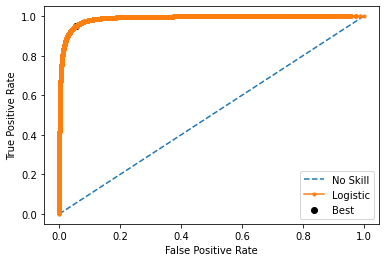

In [27]:
fpr, tpr, thresholds = roc_curve(train['class_labels'].values, train_preds)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [28]:
val_preds

array([0.02540877, 0.03297017, 0.02066709, ..., 0.9827627 , 0.98686385,
       0.98882335], dtype=float32)

In [29]:
print(f"Precision: {precision_score(test['class_labels'].values, np.where(test_preds > 0.5, 1, 0))}")
print(f"Recall: {recall_score(test['class_labels'].values, np.where(test_preds > 0.5, 1, 0))}")

Precision: 0.840958605664488
Recall: 0.9061032863849765


In [30]:
print(f"Precision: {precision_score(train['class_labels'].values, np.where(train_preds > 0.406096, 1, 0))}")
print(f"Recall: {recall_score(train['class_labels'].values, np.where(train_preds > 0.406096, 1, 0))}")

Precision: 0.8299700968193889
Recall: 0.9518213866039953


In [31]:
# model.save('../saved_model_128/')

In [47]:
res_ = keras.applications.ResNet50(include_top = False,
    input_shape = (128, 128, 3),
    weights = None, 
    pooling = 'avg')
sig = keras.layers.Dense(1, activation='sigmoid')(res_.layers[-1].output)

In [37]:
res_.layers[-1]

In [48]:
mod = keras.models.Model(inputs=res_.layers[0].input, outputs=sig)

In [49]:
mod.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [125]:
res_.set_weights(res50weights)
sigmoid_layer.set_weights(sigmoid_weights)

ValueError: You called `set_weights(weights)` on layer "dense_6" with a weight list of length 2, but the layer was expecting 0 weights. Provided weights: [array([[ 0.03903475],
       [ 0.0230649 ],
     ...

In [86]:
img = tf.io.read_file(train['fixed_paths'].values.tolist()[0])
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, size = (128, 128))
img = img / 255

In [107]:
def custom_infer(data_path):
    img = tf.io.read_file(data_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size = (128, 128))
    img = img / 255
    temp = res_.predict(img.numpy().reshape(1, 128, 128, 3), verbose=0)
    preds = sigmoid(temp)
    return preds

def actual_model(data_path):
    img = tf.io.read_file(data_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size = (128, 128))
    img = img / 255
    # temp = res_.predict(img.numpy().reshape(1, 128, 128, 3), verbose=0)
    preds = model.predict(img.numpy().reshape(1, 128, 128, 3), verbose=0)
    return preds

In [112]:
custom_preds = []
for x in tqdm(train['fixed_paths'].values.tolist()[:1000]):
    custom_preds.append(custom_infer(x))

100%|██████████| 1000/1000 [01:59<00:00,  8.36it/s]


In [113]:
actual_preds = []
for x in tqdm(train['fixed_paths'].values.tolist()[:1000]):
    actual_preds.append(actual_model(x))

100%|██████████| 1000/1000 [08:57<00:00,  1.86it/s]


In [114]:
actual_preds[:10]

[array([[0.11793849]], dtype=float32),
 array([[0.04476193]], dtype=float32),
 array([[0.38285363]], dtype=float32),
 array([[0.06439063]], dtype=float32),
 array([[0.03639622]], dtype=float32),
 array([[0.03237434]], dtype=float32),
 array([[0.9843277]], dtype=float32),
 array([[0.03357893]], dtype=float32),
 array([[0.0446183]], dtype=float32),
 array([[0.03253573]], dtype=float32)]

In [115]:
custom_preds[:10]

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.7750413]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.8023023]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.74180204]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.7893914]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.8325746]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9721983]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.97698385]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.76763284]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.7891883]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.8371881]], dtype=float32)>]